In [ ]:
# default_exp baselines

# baselines

> API details.

In [ ]:
#export
#hide
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.multioutput import MultiOutputRegressor
from sklearn.utils.validation import check_is_fitted
from sktime.transformations.panel.rocket import Rocket
from sktime.utils.data_processing import from_3d_numpy_to_nested
import matplotlib.pyplot as plt

In [ ]:
def get_test_data(n_samples=20):
    X = np.random.random_sample(n_samples)*np.pi
    y = np.sin(X) + np.random.randn(X.shape[0])*0.1+1
    
    return X.reshape(-1,1),y

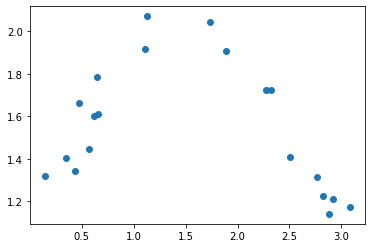

In [ ]:
X,y = get_test_data()
plt.scatter(X, y)

In [ ]:
def _append_one_col(X):
    """append array with ones in order to replace a fitted bias in the output"""
    return np.hstack([np.ones((X.shape[0], 1)), X])

In [ ]:
class BayesLinReg(BaseEstimator):
    """Batch wise linear regression"""

    def __init__(self, alpha=0.3, beta=1):
        self.alpha = alpha
        self.beta = beta
        self.n_features = None

    # inspired by https://maxhalford.github.io/blog/bayesian-linear-regression/
    def fit(self, X, y):

        # If x and y are singletons, then we coerce them to a batch of length 1
        x = np.atleast_2d(X)
        y = np.atleast_1d(y)

        X = _append_one_col(X)

        if self.n_features is None:
            self.n_features = X.shape[1]

            self.mean = np.zeros(self.n_features)
            self.cov_inv = np.identity(self.n_features) / self.alpha

        # Update the inverse covariance matrix (Bishop eq. 3.51)
        cov_inv = self.cov_inv + self.beta * X.T @ X

        # Update the mean vector (Bishop eq. 3.50)
        cov = np.linalg.inv(cov_inv)
        mean = cov @ (self.cov_inv @ self.mean + self.beta * y @ X)

        self.cov_inv = cov_inv
        self.mean = mean

        return self
    
    def _predict(self,X):
        X = np.atleast_2d(X)

        X = _append_one_col(X)

        # Obtain the predictive mean (Bishop eq. 3.58)
        y_pred_mean = X @ self.mean

        # Obtain the predictive variance (Bishop eq. 3.59)
        w_cov = np.linalg.inv(self.cov_inv)
        y_pred_var = 1 / self.beta + (X @ w_cov * X).sum(axis=1)

        # Drop a dimension from the mean and variance in case x and y were singletons
        # There might be a more elegant way to proceed but this works!
        y_pred_mean = np.squeeze(y_pred_mean)
        y_pred_var = np.squeeze(y_pred_var)
        
        return y_pred_mean, y_pred_var ** 0.5
        

    def predict(self, X):

        y_pred_mean, _ =self._predict(X)

        return y_pred_mean
    
    def predict_proba(self, X):

        y_pred_mean, y_pred_std =self._predict(X)

        # return stats.norm(loc=y_pred_mean, scale=y_pred_var ** .5)
        return y_pred_mean, y_pred_std


In [ ]:
X.shape, y.shape

((20, 1), (20,))

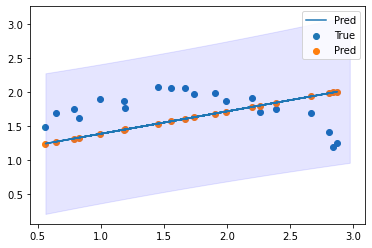

In [ ]:
# train data
X,y = get_test_data()
model = BayesLinReg()
model = model.fit(X,y)

# test data
X,y = get_test_data()
yhat, ystd = model.predict_proba(X)

fig, ax = plt.subplots()
ax.scatter(X, y, label="True")
ax.scatter(X, yhat, label="Pred")
ax.plot(X, yhat, label="Pred")

x_range = np.arange(np.min(X), np.max(X)+0.1, step=0.001).reshape(-1,1)
yhat, ystd = model.predict_proba(x_range)
ax.fill_between(x_range.reshape(-1), (yhat-ystd), (yhat+ystd), color='b', alpha=.1)

plt.legend()

In [ ]:
class RidgeRegression(BaseEstimator):
    def __init__(self, l2_reg=1e-3):
        self.l2_reg = l2_reg

    def _ridge_regression(self, X, y):
        """ridge / tikhonov regularized linear multiple, multivariate regression"""
        return np.linalg.inv(X.T @ X + self.l2_reg * np.eye(X.shape[1])) @ X.T @ y

    def fit(self, X, y):
        X = _append_one_col(X)
        self.W = self._ridge_regression(X, y)

        return self

    def predict(self, X):
        X = _append_one_col(X)
        y_hat = X @ self.W

        return y_hat


In [ ]:
def relu(x):
    return np.maximum(x, 0)

def identity(x):
    return x



In [ ]:
class ELM(BaseEstimator):
    def __init__(
        self, n_hidden=20, activations=relu, prediction_model=BayesLinReg(), **kwargs
    ):

        """[summary]

        Args:
            n_hidden (int, optional): [description]. Defaults to 100.
            activations ([type], optional): [description]. Defaults to relu.
            prediction_model_type (str, optional): [description]. Defaults to "ridge".
        """

        self.prediction_model = prediction_model
        self.n_hidden = n_hidden
        self.activations = activations

        if self.prediction_model is None:
            self._prediction_model = BayesLinReg()
        else:
            self._prediction_model = self.prediction_model

        super(ELM).__init__()

    def _as_list(self, a):
        if isinstance(a, list):
            return a
        else:
            return [a]
        
    def transform_X(self, X, W, b, activations):
        G = np.dot(X, W) + b
        Hs = []
        for act in activations:
            Hs.append(act(G))
        return np.concatenate(Hs, axis=1)

    def fit(self, X, y):

        X, y = self._validate_data(X, y, y_numeric=True, multi_output=True)

        self._n_features = X.shape[1]
        self._hidden_weights = np.random.normal(size=[self._n_features, self.n_hidden])
        self._biases = np.random.normal(size=[self.n_hidden])

        
        X_transformed = self.transform_X(
            X, self._hidden_weights, self._biases, self._as_list(self.activations)
        )
        
        self._prediction_model.fit(X_transformed, y)

        return self
    
    def _prep_pred_X(self, X):
         # Check is fit had been called
        check_is_fitted(self)

        X = self._validate_data(X)

        X_transformed = self.transform_X(
            X, self._hidden_weights, self._biases, self._as_list(self.activations)
        )
        
        return X_transformed
        

    def predict(self, X):
        X_transformed = self._prep_pred_X(X)
        y_hat = self._prediction_model.predict(X_transformed)

        return y_hat
    
    def predict_proba(self, X):
        X_transformed = self._prep_pred_X(X)
        return self._prediction_model.predict_proba(X_transformed)

    def set_params(self, **params):
        local_param_keys = self.get_params(deep=False).keys()
        local_params = {k: v for (k, v) in params.items() if k in local_param_keys}

        for k, v in local_params.items():
            setattr(self, k, v)

        # assume that remaining keys must be part of the prediction model
        non_local_params = {
            k: v for (k, v) in params.items() if k not in local_param_keys
        }
        self.prediction_model.set_params(**non_local_params)

    def get_params(self, deep=False):
        return super().get_params()

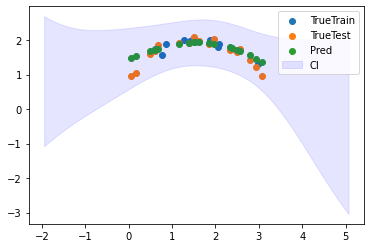

In [ ]:
X,y = get_test_data(n_samples=10)
model = ELM(n_hidden=5, activations=[np.sin], prediction_model=BayesLinReg(alpha=1, beta=10))
model = model.fit(X,y)
fig, ax = plt.subplots()
ax.scatter(X, y, label="TrueTrain")

# test data
X,y = get_test_data()
yhat, ystd = model.predict_proba(X)


ax.scatter(X, y, label="TrueTest")
ax.scatter(X, yhat, label="Pred")

x_range = np.arange(np.min(X)-2, np.max(X)+2, step=0.001).reshape(-1,1)
yhat, ystd = model.predict_proba(x_range)
ax.fill_between(x_range.reshape(-1), (yhat-1.96*ystd), (yhat+1.96*ystd), color='b', alpha=.1, label="CI")

plt.legend()

In [ ]:
class EchoStateRegression(BaseEstimator):
    def __init__(
        self,
        num_hidden=100,
        activations=[relu, np.tanh, identity],
        activation_momentum=0.9,
        prediction_model=RidgeRegression(),
    ):
        # number of input features (necessary for initialization)
        self.num_in_feature = None
        # number of hidden recurrent units
        self.num_hidden = num_hidden
        # squashing / activation function
        self.activations = activations
        # activation momentum: each recurrent activation is a moving average of the past
        self.activation_momentum = activation_momentum

        self.prediction_model = prediction_model

    def _init_params(self):
        """randomly initialize parameters"""
        # initalize input weights
        self.W_in = (
            np.random.randn(self.num_in_feature, self.num_hidden)
            * np.sqrt(2 / self.num_hidden)
            - 0.5
        )
        # initialize recurrent weights
        self.W_rec = np.random.randn(self.num_hidden, self.num_hidden)
        # compute spectral radius from recurrent weights
        spectral_radius = np.max(np.abs(np.linalg.eigvals(self.W_rec)))
        # normalize recurrent weights via the spectral radius
        self.W_rec /= spectral_radius * np.sqrt(2)
        # biases
        self.b = np.random.randn(1, self.num_hidden)

    def _run_reservoir(self, X):
        """Fcompute reservoir activations of the echo state network"""
        # get number of sequences
        num_sequences = X.shape[0]
        # get number of time steps (assumed to be equal, e.g. by padding)
        num_time_steps = X.shape[1]
        # compute the matrix product between each input sequence element and
        # the input weight matrix (einsum replaces a loop over time steps)
        H_in = np.einsum("ijk,kl", X, self.W_in)

        H_recs = []
        # initialize recurrent activation with zeros
        for act_func in self.activations:
            H_rec = np.zeros((num_sequences, self.num_hidden))
            # loop all time steps
            for time_step in range(num_time_steps):
                # compute recurrent input from previous time step recurrent activation
                rec = H_rec @ self.W_rec
                # comput hidden recurrent activation for next time step
                H_rec = (1 - self.activation_momentum) * act_func(
                    H_in[:, time_step, :] + rec + self.b
                ) + self.activation_momentum * H_rec
            H_recs.append(H_rec)

        H_rec = np.concatenate(H_recs, axis=1)
        # return final activation for the last time step
        return H_rec

    def fit(self, X, y):
        """Fitting a echo state network with a single time step forecast horizon."""

        if self.num_in_feature == None:
            self.num_in_feature = X.shape[2]
            self._init_params()
        # compute reservoir activations
        H = self._run_reservoir(X)

        self.prediction_model = MultiOutputRegressor(self.prediction_model)
        self.prediction_model = self.prediction_model.fit(H, y)

        return self

    def predict(self, X):
        """Predicting the trained echo state network"""
        # assert that number of input features was correct
        assert self.num_in_feature == X.shape[2]
        # compute reservoir activations
        H = self._run_reservoir(X)
        # append array with ones in order to replace a fitted bias in the output
        return self.prediction_model.predict(H)

In [ ]:
class RocketReservoirRegression(BaseEstimator):
    def __init__(
        self, num_kernels=1000, prediction_model=RidgeRegression(), normalise=False
    ):
        self.num_kernels = num_kernels
        self.prediction_model = prediction_model
        self.rocket = Rocket(num_kernels=num_kernels, normalise=normalise)

    def fit(self, X, y):
        """expects array of dimensions num_samples X timesteps X num features"""
        X_transformed = from_3d_numpy_to_nested(X.swapaxes(1, 2))
        X_transformed = self.rocket.fit_transform(X_transformed)

        self.prediction_model = MultiOutputRegressor(self.prediction_model)
        self.prediction_model = self.prediction_model.fit(X_transformed, y)

        return self

    def predict(self, X):
        X_transformed = from_3d_numpy_to_nested(X.swapaxes(1, 2))
        X_transformed = self.rocket.transform(X_transformed)

        yhat = self.prediction_model.predict(X_transformed)

        return yhat